In [59]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse, schedule

from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional, Union

IBMQ.load_account()

ibmqfactory.load_account:WARNING:2024-01-07 00:11:43,960: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [60]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_algiers') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQ

In [61]:
DEBUG_PRINT = False

backend = provider.get_backend('ibm_cairo') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = qubit_0

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

In [62]:
from helper_funcs.utils import *

tau_1 = get_dt_from(46.2 * ns) * dt
tau_2 = get_dt_from(270 * ns) * dt

tau_3_est_linspace = np.array([66, 77, 88]) * ns
tau_3_est_linspace = convert_arr_to_dt(tau_3_est_linspace)
print(tau_3_est_linspace/ns)

tau_4_est = 50 * ns
tau_4_span = 30 * ns
num_tau_4_exp = 10
tau_4_linspace = np.linspace(-0.5 * tau_4_span + tau_4_est, 0.5 * tau_4_span + tau_4_est, num_tau_4_exp)
tau_4_linspace = convert_arr_to_dt(tau_4_linspace)
print(tau_4_linspace/ns)

freq_span = 7. * MHz
freq_center = -2. * MHz
num_freq_exp = 38
ac_freq_linspace = np.linspace(-0.5 * freq_span + freq_center, 0.5 * freq_span + freq_center, num_freq_exp)
print(ac_freq_linspace/MHz)

[67.55555556 78.22222222 88.88888889]
[35.55555556 39.11111111 42.66666667 46.22222222 49.77777778 53.33333333
 53.33333333 56.88888889 60.44444444 64.        ]
[-5.5        -5.31081081 -5.12162162 -4.93243243 -4.74324324 -4.55405405
 -4.36486486 -4.17567568 -3.98648649 -3.7972973  -3.60810811 -3.41891892
 -3.22972973 -3.04054054 -2.85135135 -2.66216216 -2.47297297 -2.28378378
 -2.09459459 -1.90540541 -1.71621622 -1.52702703 -1.33783784 -1.14864865
 -0.95945946 -0.77027027 -0.58108108 -0.39189189 -0.2027027  -0.01351351
  0.17567568  0.36486486  0.55405405  0.74324324  0.93243243  1.12162162
  1.31081081  1.5       ]


In [63]:
comp_vals = np.array(np.meshgrid(tau_3_est_linspace, tau_4_linspace)).reshape(2, -1).T

total_exp = []

for (tau_3, tau_4) in comp_vals:
    tau_3_dt = get_dt_from(tau_3)
    tau_4_dt = get_dt_from(tau_4)

    for freq_shift in ac_freq_linspace:
        with pulse.build(
            backend=backend,
            default_alignment='sequential',
            name=f'AC Stark Photon Meas, tau 3: {int(1e2*tau_3_dt*dt/ns)/1e2}, tau 4: {int(1e2*tau_4_dt*dt/ns)/1e2}, freq shift: {int(1e3*freq_shift/MHz)/1e3}MHz'
        ) as ac_freq_sched:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)

            pulse.shift_frequency(freq_shift, qubit_chan)

            pulse.play(
                pulse.Constant(duration=get_dt_from(tau_1), amp=1.0),
                meas_chan
            )
            pulse.play(
                pulse.Constant(duration=get_dt_from(tau_2 - tau_1), amp=measure_pulse.amp),
                meas_chan
            )
            pulse.play(
                pulse.Constant(duration=tau_3_dt, amp=-1.0),
                meas_chan
            )
            pulse.play(
                pulse.Constant(duration=tau_4_dt, amp=1.0),
                meas_chan
            )
            pulse.delay(2 * measure_pulse.sigma, qubit_chan)
            pulse.play(x_pulse, qubit_chan)
            pulse.delay(measure_delay.duration, meas_chan)
            pulse.measure(qubit, pulse.MemorySlot(qubit))
        total_exp.append(ac_freq_sched)

print(len(total_exp))
acquisition_checker(total_exp)

1140


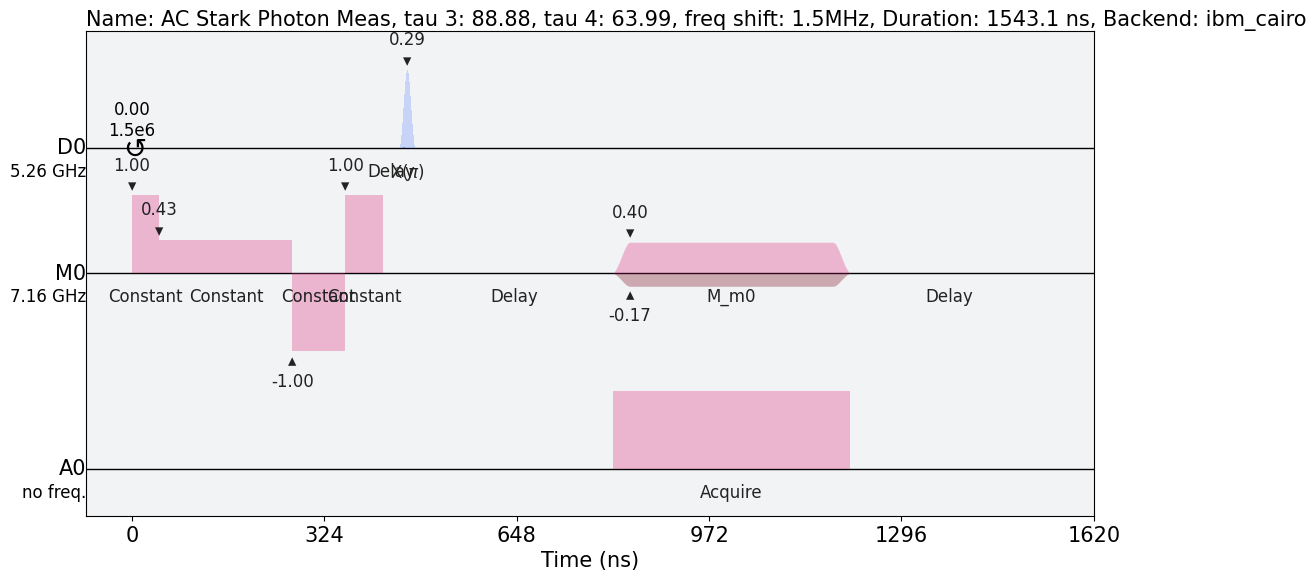

In [64]:
total_exp[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

285


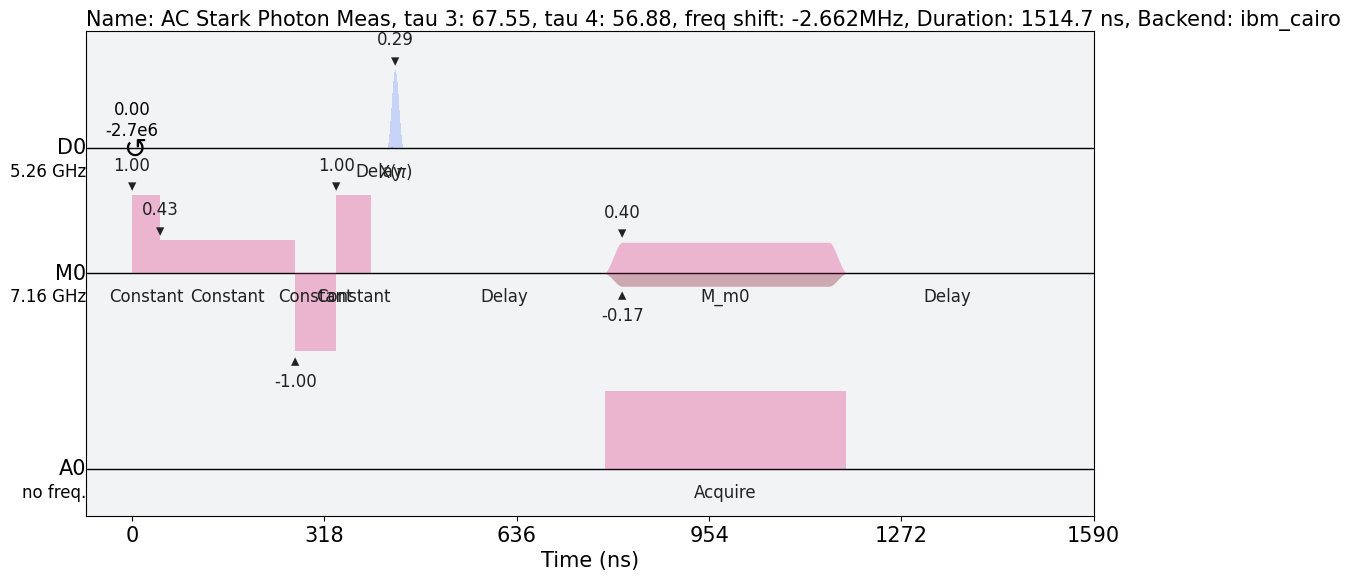

In [65]:
exp_1, exp_2, exp_3, exp_4 = np.array(total_exp).reshape(4, -1).tolist()
print(len(exp_1))
exp_3[-42].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

In [66]:
num_shots = 4096
rep_delay = 499.0 * 1e-6

In [70]:
job_experiment = backend.run(exp_4, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

/Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/qiskit/compiler/assembler.py:443: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job is queued

KeyboardInterrupt: 

In [71]:
job_1 = provider.backend.retrieve_job('cpcsy1r2zy6g008nzfb0')
job_2 = provider.backend.retrieve_job('cpcsy5rja3gg0080xse0')
job_3 = provider.backend.retrieve_job('cpcsyb9mbjng0085z9fg')
job_4 = provider.backend.retrieve_job('cpcsye92zy6g008nzfc0')

In [72]:
result_1 = get_results_arr(job_1.result(), qubit)
result_2 = get_results_arr(job_2.result(), qubit)
result_3 = get_results_arr(job_3.result(), qubit)
result_4 = get_results_arr(job_4.result(), qubit)

In [86]:
means_1 = np.angle(np.mean(result_1, axis=-1))
means_2 = np.angle(np.mean(result_2, axis=-1))
means_3 = np.angle(np.mean(result_3, axis=-1))
means_4 = np.angle(np.mean(result_4, axis=-1))

big_res = np.concatenate((means_1, means_2, means_3, means_4)).reshape(-1, num_freq_exp)
big_res = big_res.reshape(-1, 3, num_freq_exp).swapaxes(0, 1)
print(big_res.shape)

(3, 10, 38)


In [85]:
arr = np.arange(30).reshape(-1, 3).swapaxes(0, 1)
print(arr[0])

[ 0  3  6  9 12 15 18 21 24 27]


In [108]:
from scipy.optimize import curve_fit

res = big_res[2]

big_fit_res = np.zeros_like(res)
big_freqs = np.zeros(len(res))
print(res.shape)

for ind, res_obj in enumerate(res):
    init_params = [0.1, -1., 10., -1.1]
    # params, res = fit_gaussian_with_offset(ac_freq_linspace/MHz, res_obj, init_params)
    params, cov = curve_fit(gaussian_func_with_offset, ac_freq_linspace/MHz, res_obj, init_params, maxfev=10000)
    res = gaussian_func_with_offset(ac_freq_linspace/MHz, *params)
    big_fit_res[ind] = res
    big_freqs[ind] = params[1]

(10, 38)


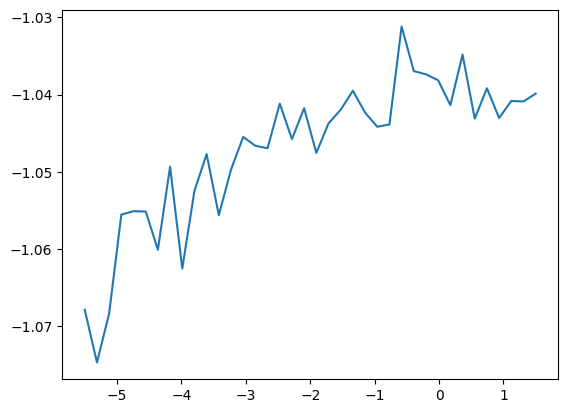

In [109]:
plt.plot(ac_freq_linspace/MHz, big_res[2, 7])
plt.show()

7
0.032606155726460036
56.888888888888886


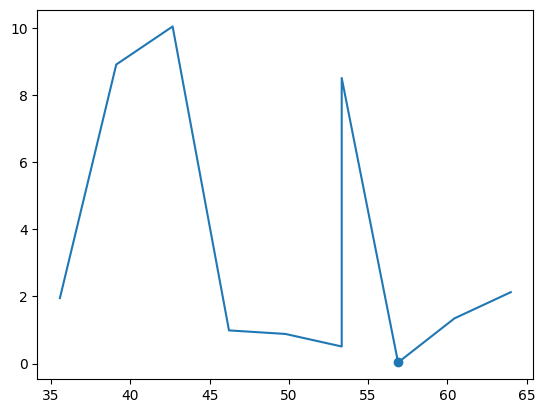

In [105]:
photons = np.abs(-big_freqs/0.65)
ind = np.argmin(photons)
print(ind)
print(photons[ind])
print(tau_4_linspace[ind]/ns)

plt.plot(tau_4_linspace/ns, photons)
plt.scatter(tau_4_linspace[ind]/ns, photons[ind])
plt.show()

0.9611121388333899


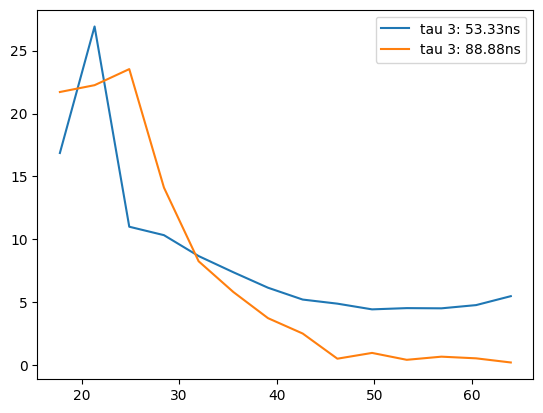

In [43]:
photons = np.abs(-big_freqs/0.65)

ind = np.argmin(photons) - 8
print(photons[ind])

photons_reshaped = photons.reshape(-1, 2).T

for ind, photon_res in enumerate(photons_reshaped):
    plt.plot(tau_4_linspace/ns, photon_res, label=f'tau 3: {int(1e2*tau_3_est_linspace[ind]/ns)/1e2}ns')
plt.legend()
plt.show()

120ns for single tone reset + wait, Easier to Calibrate, more Stable \
140ns for double tone active reset, Tougher to Calibrate, less Stable \

100ns for reset is tolerable

In [112]:
arr = np.arange(30).reshape(-1, 1)
ones_arr = np.ones_like(arr).reshape(-1, 1)

comp_arr = np.concatenate((ones_arr, arr), axis=-1).flatten()
print(comp_arr)

[ 1  0  1  1  1  2  1  3  1  4  1  5  1  6  1  7  1  8  1  9  1 10  1 11
  1 12  1 13  1 14  1 15  1 16  1 17  1 18  1 19  1 20  1 21  1 22  1 23
  1 24  1 25  1 26  1 27  1 28  1 29]


In [114]:
comp_arr = comp_arr.reshape(-1, 2)
print(comp_arr)

[[ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  8]
 [ 1  9]
 [ 1 10]
 [ 1 11]
 [ 1 12]
 [ 1 13]
 [ 1 14]
 [ 1 15]
 [ 1 16]
 [ 1 17]
 [ 1 18]
 [ 1 19]
 [ 1 20]
 [ 1 21]
 [ 1 22]
 [ 1 23]
 [ 1 24]
 [ 1 25]
 [ 1 26]
 [ 1 27]
 [ 1 28]
 [ 1 29]]
